# Online Correlation Changepoint Detection via Adaptive EWMA Charts

This notebook investigates **real-time detection of shifts in correlation** between two time series. The goal is to detect a correlation changepoint as early as possible using only past data.

To do so, we propose to monitor the **rolling Pearson correlation** between paired data streams based on a fixed rolling window. We then propose the **Adaptive EWMA** chart, which updates its EWMA forgetting factor based on one-step prediction error. We evaluate and compare it against three other online changepoint detection methods:

- **CUSUM** – classical mean-shift detector applied to rolling correlation  
- **Wilcoxon Rank-Sum Scan** – non-parametric, windowed scan method  
- **MEWMA** – multivariate EWMA on the bivariate raw stream  

This work is part of a Master's thesis:

> **Online Correlation Changepoint Detection via Adaptive EWMA Charts**  
> *Jilly Lim — Imperial College London, 2025*<br>
> MSc Machine Learning and Data Science *(Online)*

The notebook includes:
- Controlled simulations and calibration of each method  
- Real-world case studies:  
  - Stock prices (e.g. NVDA vs GOOGL, Zoom vs S&P 500)  
  - COVID-19 cases (Los Angeles vs San Francisco)


In [169]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ranksums
import itertools

try:
    import kagglehub
except ImportError:
    raise ImportError("Please `pip install kagglehub` to fetch datasets used in the case studies.")


# Synthetic Data Generation & Rolling Correlation

## Generation Functions

First we generate synthetic Gaussian datastreams $(X_t, Y_t)$ for our simulation study outlined in Section 4.1 of the thesis.

In [5]:
def generate_bivariate_stream(rho0=0.20, v=50, G=180, D=300, delta=0.7, mode='test', seed=None):
    """
    Generate a synthetic data stream (X_t, Y_t) with a jump in correlation at time tau.

    Parameters:
    - rho0: baseline correlation before the jump
    - v: lambda parameter for Poisson jitter xi
    - G: grace period before the jump
    - D: dwell period after the jump
    - delta: jump size
    - mode: 'test' for streams with jumps, 'control' for no-jump streams
    - seed: optional RNG seed

    Returns: 
    - df: columns ['X', 'Y'] of observations
    - tau: the changepoint
    """
    if seed is not None:
        np.random.seed(seed)

    if not -1 < rho0 < 1:
        raise ValueError("rho0 must be between -1 and 1")

    # Randomize jump location via poisson (lambda=v) RV.
    xi = np.random.poisson(lam=v)
    tau = G + xi
    delta = delta if mode=='test' else 0.0
    theta = np.random.choice([1, -1]) if mode=='test' else 0
    jump = theta * delta

    # Generate observations.
    total_length = tau + D
    X = np.zeros(total_length)
    Y = np.zeros(total_length)
    cov0 = [[1, rho0], [rho0, 1]]
    rho1 = rho0 + jump
    rho1 = max(min(rho1, 0.9999), -0.9999)  # cap rho1 to (-1, 1)
    cov1 = [[1, rho1], [rho1, 1]]
    pre = np.random.multivariate_normal(mean=[0,0], cov=cov0, size=tau)
    post = np.random.multivariate_normal(mean=[0,0], cov=cov1, size=D)
    X[:tau], Y[:tau] = pre[:,0], pre[:,1]
    X[tau:], Y[tau:] = post[:,0], post[:,1]
    df = pd.DataFrame({'X': X, 'Y': Y})

    return df, tau


We can visualize a single sample bivariate stream. At a first glance, it is hard to tell when the relationship between the two variables change.

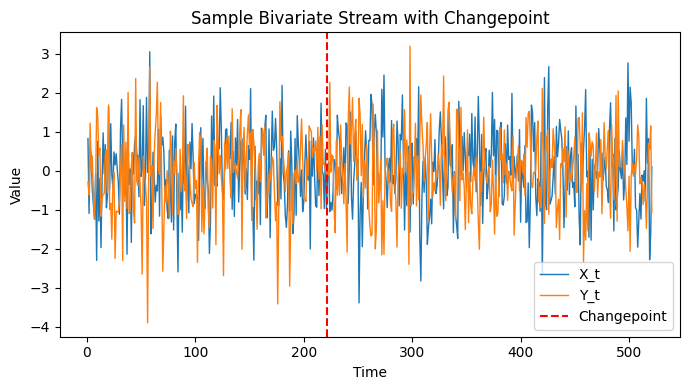

In [6]:
# Visualize a sample bivariate stream.

df, tau = generate_bivariate_stream(rho0=0.2, seed=227)

plt.figure(figsize=(7, 4))
plt.plot(df.index + 1, df['X'], linewidth=1, label='X_t')
plt.plot(df.index + 1, df['Y'],  linewidth=1, label='Y_t')
plt.axvline(tau, linestyle='--', color='red', label='Changepoint')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sample Bivariate Stream with Changepoint')
plt.legend()
plt.tight_layout()
plt.show()


Based on these bivariate streams, we then generate the rolling Pearson correlation $r_t$ based on a fixed window size, which is described in detail in Section 3.2.

In [ ]:
def rolling_corr(df, window=60):
    """Compute rolling Pearson r_t over last window points.

    Parameters:
    - df: columns ['X', 'Y'] of observations
    - window: length of last observations
    
    Returns:
    - r_t: correlation between X and Y over window
    """

    return df['X'].rolling(window).corr(df['Y']).fillna(0)

We can check the empirical mean and covariance before and after tau. The example below shows that the empirical values arein line with the "expected" change based on our pre-determined delta values.

In [8]:
# Compute the empirical mean and covariance before and after tau

pre = df.iloc[:tau]
post = df.iloc[tau:]
mean_pre = pre.mean()
mean_post = post.mean()
cov_pre = pre.cov()
cov_post = post.cov()

print("Pre-change mean:")
print(mean_pre)
print("\nPre-change covariance:")
print(cov_pre)

print("\nPost-change mean:")
print(mean_post)
print("\nPost-change covariance:")
print(cov_post)

corr_pre  = cov_pre.loc['X','Y'] / np.sqrt(cov_pre.loc['X','X'] * cov_pre.loc['Y','Y'])
corr_post = cov_post.loc['X','Y'] / np.sqrt(cov_post.loc['X','X'] * cov_post.loc['Y','Y'])

print("\nEmpirical ρ_pre =", corr_pre)
print("Empirical ρ_post =", corr_post)


Pre-change mean:
X   -0.019767
Y   -0.092577
dtype: float64

Pre-change covariance:
          X         Y
X  0.965747  0.178783
Y  0.178783  1.057241

Post-change mean:
X    0.068725
Y    0.019736
dtype: float64

Post-change covariance:
          X         Y
X  1.003362 -0.514812
Y -0.514812  0.896793

Empirical ρ_pre = 0.17693242960185115
Empirical ρ_post = -0.5427170615911058


## Rolling Correlation Window Size 

Different window sizes results in varying levels of stability in the rolling correlation, visually revealing the trade-off between stability of values and ability to detect meaningful changes after a changepoint.

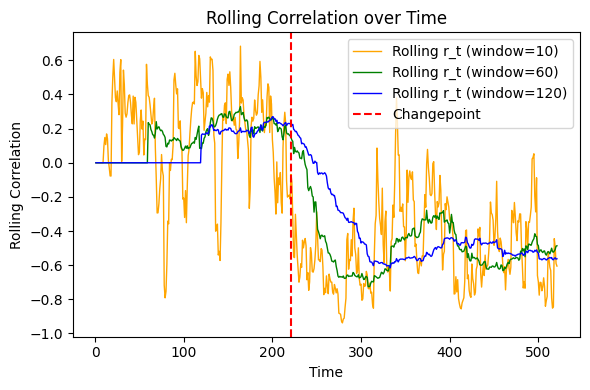

In [9]:
# Visualize trade off of r's stability and responsiveness to change.

w1 = 10
w2 = 60
w3 = 120

r1 = rolling_corr(df, window=w1)
r2 = rolling_corr(df, window=w2)
r3 = rolling_corr(df, window=w3)

plt.figure(figsize=(6, 4))
plt.plot(df.index + 1, r1, color='orange', linewidth=1, label=f'Rolling r_t (window={w1})')
plt.plot(df.index + 1, r2, color='green', linewidth=1, label=f'Rolling r_t (window={w2})')
plt.plot(df.index + 1, r3, color='blue', linewidth=1, label=f'Rolling r_t (window={w3})')
plt.axvline(tau, linestyle='--', color='red', label='Changepoint')
plt.xlabel('Time')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation over Time')
plt.legend()
plt.tight_layout()
plt.show()


We can quantify this variance in $r_t$ using the closed form variance approximation of $r_t$, which depends on the size of correlation $\rho$ and the window size $w$.

We set $\rho_0=0.2$ so that a large shift of about $0.7$ from baseline is feasible within $[-1, 1]$.

In [10]:
# Calculate closed-form variance approximation of r_t over different window sizes, for rho0=0.2.

def closed_form_var_rho(w, rho):
    return ((1 - rho**2)**2) / (w - 1)

rho = 0.2 # same as sample df above.
window_sizes = np.array([10, 30, 60, 90, 120])
closed_form_vars = closed_form_var_rho(window_sizes, rho)
df_closed_form = pd.DataFrame({
    "rho": rho,
    "Window Size": window_sizes,
    "Closed-Form Var(r)": closed_form_vars
})

df_closed_form


,rho,Window Size,Closed-Form Var(r)
0,0.2,10,0.102400
1,0.2,30,0.031779
2,0.2,60,0.015620
3,0.2,90,0.010355
4,0.2,120,0.007745


In [11]:
# Just to demonstrate values of a rho closer to 1.

rho = 0.9
window_sizes = np.array([10, 30, 60, 90, 120])
closed_form_vars = closed_form_var_rho(window_sizes, rho)
df_closed_form = pd.DataFrame({
    "rho": rho,
    "Window Size": window_sizes,
    "Closed-Form Var(r)": closed_form_vars
})

df_closed_form

# Expected variance of r is closer to 0.

,rho,Window Size,Closed-Form Var(r)
0,0.9,10,0.004011
1,0.9,30,0.001245
2,0.9,60,0.000612
3,0.9,90,0.000406
4,0.9,120,0.000303


Based on our results, we choose $w=60$, as we are okay with the expected variance of $r_t = 0.0156$.

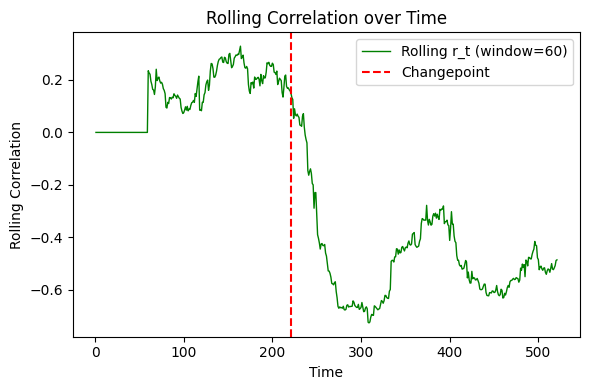

In [12]:
# We use window = 60 based on the trade off analysis.

r60 = rolling_corr(df, window=60)
tau_map = tau

plt.figure(figsize=(6, 4))
plt.plot(r60.index + 1, r60, color='green', linewidth=1, label='Rolling r_t (window=60)')
plt.axvline(tau_map, linestyle='--', color='red', label='Changepoint')
plt.xlabel('Time')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation over Time')
plt.legend()
plt.tight_layout()
plt.show()


## Properties of Rolling Correlation

We can visualize the distribution of $r_t$ with histograms and q-q plots, which reveal that $r_t$ has a skewed distribution, not normal.

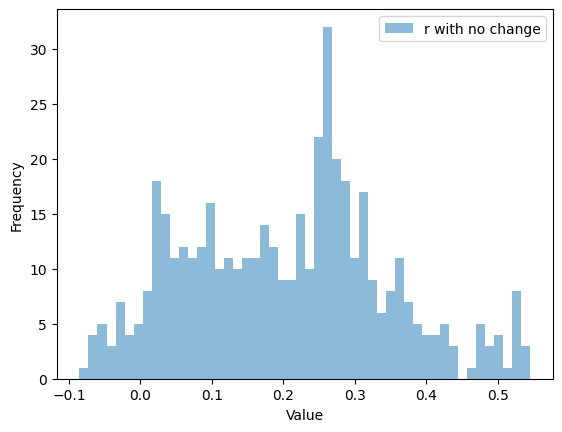

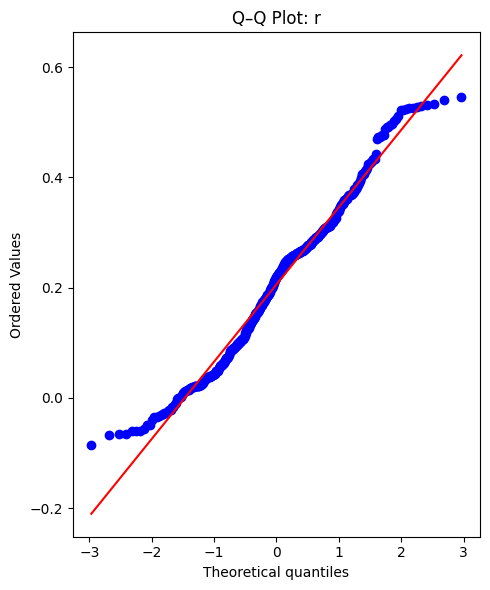

In [ ]:
# Histogram and qq plot of r with no change shows r is not normally distributed.

df, tau = generate_bivariate_stream(mode='control', rho0=0.2, seed=227)
window = 60
r60 = rolling_corr(df, window=window)

plt.figure()
plt.hist(r60[window:], bins=50, alpha=0.5, label='r with no change')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5, 6))
stats.probplot(r60[window:], dist='norm', plot=ax)
ax.set_title('Q–Q Plot: r')
plt.tight_layout()
plt.show()


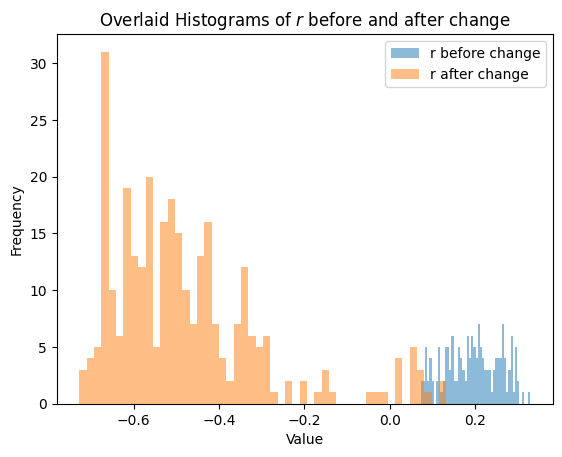

In [ ]:
# Similarly, r with a changepoint is not normally distributed before and after the changepoint.

df, tau = generate_bivariate_stream(mode='test', rho0=0.2, seed=227)
window = 60
r60 = rolling_corr(df, window=window)

plt.figure()
plt.hist(r60[window:tau], bins=50, alpha=0.5, label='r before change')
plt.hist(r60[tau:], bins=50, alpha=0.5, label='r after change')
plt.title('Overlaid Histograms of $r$ before and after change')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# r is right skewed roughly around rho0 pre change, and left skewed roughly around rho1 post change.

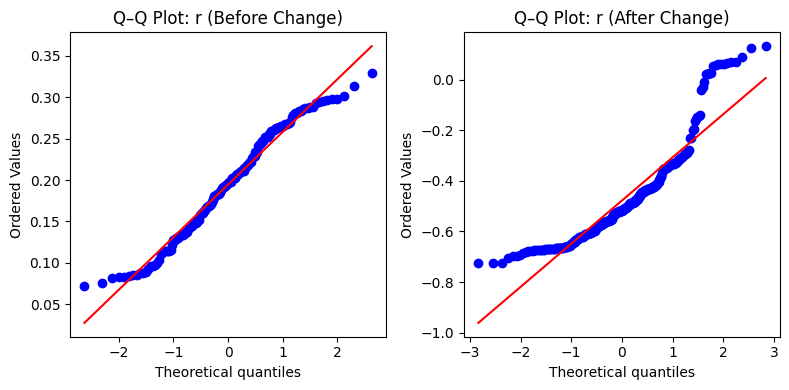

In [ ]:
# Qq plots confirm r is not normal pre and post change.
# Adaptive methods may work well for this data given its adaptability.

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
stats.probplot(r60[window:tau], dist='norm', plot=axes[0])
axes[0].set_title('Q–Q Plot: r (Before Change)')
stats.probplot(r60[tau:], dist='norm', plot=axes[1])
axes[1].set_title('Q–Q Plot: r (After Change)')
plt.tight_layout()
plt.show()

We are now ready to dive into the benchmark and proposed methods we will apply to the rolling correlation streams.

# Benchmark Detectors

We discuss the three benchmark detectors evaluated on simulated rolling correlation streams. Details of hyperparameter tuning are provided in the Appendix of the thesis, with key decisions also annotated inline within the code for clarity.

## Benchmark Detector 1: CUSUM

The CUSUM chart, first proposed by Page (1954), tracks the cumulative sum of deviations from a reference mean and signals an alarm as soon as that sum exceeds a preset threshold. In our setup, the grace period is used to estimate the in‐control mean $\mu_0$.  

The CUSUM recursions are:

$S_0^+ = 0, \quad S_t^+ = \max\bigl(0,\,S_{t-1}^+ + X_t - \mu_0 - k\bigr),$  
$S_0^- = 0, \quad S_t^- = \max\bigl(0,\,S_{t-1}^- + \mu_0 - X_t - k\bigr),$  

and an alarm is raised as soon as $S_t^+ > h$ or $S_t^- > h$.


In [16]:
def detect_cusum(x, mu0, k, h):
    """
    Run a two-sided CUSUM chart on data x.
    
    Parameters:
    - x: 1D array of observations
    - mu0: reference (in-control) mean
    - k: reference value (typically expected change size divided by 2)
    - h: threshold for signaling
    
    Returns:
    - t_alarm: time index when either S_pos > h or S_neg > h, or None if no alarm
    """
    S_pos = 0.0  # Detect positive shifts
    S_neg = 0.0  # Detect negative shifts
    for t, xt in enumerate(x, start=1):
        S_pos = max(0.0, S_pos + (xt - mu0) - k)
        S_neg = max(0.0, S_neg + (mu0 - xt) - k)
        if S_pos > h or S_neg > h:
            return t
    return None


We simulate CUSUM detector performance and calibrate parameters based on detection timing and ARL1.

In [17]:
# Skip window + burn_in period for calibration & evaluation.

def evaluate_cusum_corr(window, h, k, burn_in, n_runs):
    # Evaluate ARL0 at h.
    fa_times = []
    for run in range(n_runs):
        df, _ = generate_bivariate_stream(mode='control', seed=run)
        S = rolling_corr(df, window=window)
        mu0_est = S[window:window+burn_in].mean()
        t_fa = detect_cusum(S[window+burn_in:], mu0_est, k, h) or len(S[window+burn_in:]) + 1
        fa_times.append(t_fa)
    arl0_empirical = np.mean(fa_times)

    # Evaluate ARL1 at h, and calculate the detection timing counts.
    count_before = count_after = count_never = 0
    delays = []
    for run in range(n_runs):
        df, tau = generate_bivariate_stream(mode='test', seed=run)
        S = rolling_corr(df, window=window)
        mu0_est = S[window:window+burn_in].mean()
        t_alarm = detect_cusum(S[window+burn_in:], mu0_est, k, h)
        if t_alarm is None:
            count_never += 1
        elif t_alarm + window + burn_in < tau: # line up alarm index with original index.
            count_before += 1
        else:
            count_after += 1
            delays.append(t_alarm + window + burn_in - tau)

    arl1 = np.mean(delays) if delays else float('nan')

    return h, arl0_empirical, arl1, count_before, count_after, count_never


In [18]:
def evaluate_cusum_corr_params(
    burn_in_list, k_list, window=60, h_list=None, n_runs=200
):
    """
    Evaluate CUSUM on the rolling correlation stream over multiple parameter combinations.

    Parameters:
    - burn_in_list: list of initial points used to estimate mu0
    - k_list: list of expected correlation shifts divided by 2
    - window: rolling correlation window size
    - h_list: list of CUSUM thresholds
    - n_runs: number of Monte Carlo runs

    Returns:
    - DataFrame indexed by (burn_in, delta, window, h) with empirical ARL0, ARL1,
      and counts of alarms: before, after, never
    """
    results = []

    for burn_in, k, h in itertools.product(burn_in_list, k_list, h_list):
        k = k
        h_used, arl0_emp, arl1_emp, count_before, count_after, count_never = evaluate_cusum_corr(
            window=window,
            h=h,
            k=k,
            burn_in=burn_in,
            n_runs=n_runs
        )
        results.append({
            "burn_in":        burn_in,
            "window":         window,
            "h":              h_used,
            "n_runs":         n_runs,
            "k":              k,
            "ARL0_empirical": arl0_emp,
            "ARL1_empirical": arl1_emp,
            "count_before":   count_before,
            "count_after":    count_after,
            "count_never":    count_never
        })

    df = pd.DataFrame(results)
    df.set_index(['burn_in', 'k', 'window', 'h'], inplace=True)
    return df


In [19]:
# Vary burn-in and h. May improve mu0 estimate and reduce early alerts.
# Since mu0 is estimated between window and window+burn_in, the length of mu0 estimation is simply burn_in.

results_df = evaluate_cusum_corr_params(
    burn_in_list=[30, 60, 90],
    k_list=[0.35], # Try expected change / 2
    window=60,
    h_list=[0.5, 0.6, 0.7, 0.8],
    n_runs=200
)

results_df

# Longer burn in period for estimating mu0 of r seems to work best, reducing early alerts.
# Also, there are ~30 days delay (ARL1) which is reasonable.


n_runs  ARL0_empirical  ARL1_empirical  count_before  \
burn_in k    window h                                                           
30      0.35 60     0.5     200         388.080       38.400000            20   
                    0.6     200         393.380       39.872928            19   
                    0.7     200         396.895       40.840659            18   
                    0.8     200         399.300       41.670270            15   
60      0.35 60     0.5     200         368.515       38.042105            10   
                    0.6     200         374.475       38.910526            10   
                    0.7     200         377.280       39.937173             9   
                    0.8     200         382.630       40.816754             9   
90      0.35 60     0.5     200         345.915       38.041237             6   
                    0.6     200         353.415       38.948454             6   
                    0.7     200         359.105       39.784615             5   
                    0.8     200         362.285       40.663265             4   

                         count_after  count_never  
burn_in k    window h                              
30      0.35 60     0.5          180            0  
                    0.6          181            0  
                    0.7          182            0  
                    0.8          185            0  
60      0.35 60     0.5          190            0  
                    0.6          190            0  
                    0.7          191            0  
                    0.8          191            0  
90      0.35 60     0.5          194            0  
                    0.6          194            0  
                    0.7          195            0  
                    0.8          196            0

In [20]:
# Vary k.

results_df = evaluate_cusum_corr_params(
    burn_in_list=[90],
    k_list=[0.25, 0.35, 0.45],
    window=60,
    h_list=[0.6, 0.7, 0.8],
    n_runs=200
)

results_df

# Larger delta seems to work best, regardless of h ranging between 0.6 and 0.8.
# So in real life, we may want to test a few different CUSUM variable k based on known historical events in order to set k.


n_runs  ARL0_empirical  ARL1_empirical  count_before  \
burn_in k    window h                                                           
90      0.25 60     0.6     200         267.270       31.275862            26   
                    0.7     200         276.915       31.852273            24   
                    0.8     200         278.965       32.367232            23   
        0.35 60     0.6     200         353.415       38.948454             6   
                    0.7     200         359.105       39.784615             5   
                    0.8     200         362.285       40.663265             4   
        0.45 60     0.6     200         379.410       50.035354             1   
                    0.7     200         379.440       51.150754             0   
                    0.8     200         379.460       51.934673             0   

                         count_after  count_never  
burn_in k    window h                              
90      0.25 60     0.6          174            0  
                    0.7          176            0  
                    0.8          177            0  
        0.35 60     0.6          194            0  
                    0.7          195            0  
                    0.8          196            0  
        0.45 60     0.6          198            1  
                    0.7          199            1  
                    0.8          199            1

In [21]:
# Best params: burn in 90, k = 0.45, h = 0.7

results_df = evaluate_cusum_corr_params(
    burn_in_list=[90],
    k_list=[0.45],
    window=60,
    h_list=[0.7],
    n_runs=200
)

results_df

,,,,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
burn_in,k,window,h,,,,,,
90,0.45,60,0.7,200,379.44,51.150754,0,199,1


## Benchmark Detector 2: Wilcoxon Ranksum Sequential Test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html

The Wilcoxon rank-sum test (Wilcoxon, 1945) is a nonparametric method for detecting differences between two independent samples. 

In our scan-based framework, the rolling correlation series is retrospectively split at every possible point within a historical window, subject to minimum window size. For each candidate split, the test statistic comparing the ranks before and after the split is computed. We then take the maximum absolute test statistic across all splits and compare it to a fixed threshold. 

An alarm is triggered when this maximum exceeds the threshold $H_W$, indicating a likely changepoint. This method adapts to shifts of unknown timing and is robust to non-normality, skewness, and heavy tails.


In [163]:
# Use RankSum and also threshold value instead of pvalue which is more sensitive to correlation.

def detect_ranksum(x, w_min=20, H=10.0):
    """
    Run a Wilcoxon Ranksum sliding-window detector on data x.
    
    Parameters:
    - x: 1D array of observations
    - w_min: minimum comparison window size
    - H: threshold for signaling
    
    Returns:
    - t_alarm: time index when zmax >= H, or None if no alarm
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    stat = np.full(n, np.nan)
    for t in range(2*w_min, n+1):
        z = [abs(ranksums(x[:k], x[k:t]).statistic) for k in range(w_min, t-w_min+1)]
        zmax = np.max(z)
        stat[t-1] = zmax
        if zmax >= H:
            return t
    return None


We simulate WRS detector performance and calibrate parameters.

First, we try the detector on a single $r_t$ stream, where $\tau=241$ (true changepoint).

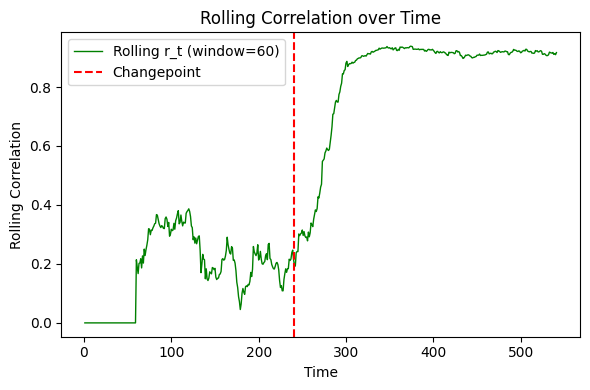

241


In [164]:
df2, tau2 = generate_bivariate_stream(rho0=0.2, seed=150)
r60_v2 = rolling_corr(df2, window=60)
tau_map_v2 = tau2

plt.figure(figsize=(6, 4))
plt.plot(r60_v2.index + 1, r60_v2, color='green', linewidth=1, label='Rolling r_t (window=60)')
plt.axvline(tau_map_v2, linestyle='--', color='red', label='Changepoint')
plt.xlabel('Time')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation over Time')
plt.legend()
plt.tight_layout()
plt.show()

print(tau2)

We try a few different ranges of $H$, landing on $H=10.2$ which results in a detection at $t=243$, only 2 days after the true $\tau$. 

Minimum window size $10$ and $30$ results in the same first detection. To reduce computational costs, we choose minimum window $30$.

In [165]:
window = 60
r60 = rolling_corr(df2, window=window)
w_min = 10
H = 10.2

detect_ranksum(r60[window:], w_min=w_min, H=H) + window # Realign index to r60.

243

In [ ]:
window = 60
r60 = rolling_corr(df2, window=window)
w_min = 30
H = 10.2

detect_ranksum(r60[window:], w_min=w_min, H=H) + window # Realign index to r60.


243

We calibrate at scale now.

In [166]:
def evaluate_ranksum_corr(window, w_min, H, n_runs):
    # Evaluate ARL0 at H
    fa_times = []
    for run in range(n_runs):
        df, _ = generate_bivariate_stream(mode='control', seed=run)
        S = rolling_corr(df, window=window)
        t_fa = detect_ranksum(S[window:], w_min=w_min, H=H)
        t_fa_scalar = t_fa if t_fa is not None else len(S[window:]) + 1
        fa_times.append(t_fa_scalar)
    arl0_empirical = np.mean(fa_times)

    count_before = count_after = count_never = 0
    delays = []
    for run in range(n_runs):
        df, tau = generate_bivariate_stream(mode='test', seed=run)
        S = rolling_corr(df, window=window)
        t_alarm = detect_ranksum(S[window:], w_min=w_min, H=H)
        if t_alarm is None:
            count_never += 1
        elif t_alarm + window < tau:
            count_before += 1
        else:
            count_after += 1
            delays.append(t_alarm + window - tau)
    arl1_empirical = np.mean(delays) if delays else float('nan')

    return H, arl0_empirical, arl1_empirical, count_before, count_after, count_never



In [167]:
def evaluate_ranksum_corr_params(w_min_list, H_list, window=60, n_runs=10):
    """
    Evaluate Wilcoxon Ranksum sliding-window detector on the rolling correlation stream
    over multiple parameter combinations.

    Parameters:
    - w_min_list: list of minimum comparison window sizes.
    - H_list: list of test thresholds.
    - window: rolling correlation window size
    - n_runs: number of Monte Carlo runs.

    Returns:
    - Data frame indexed by (w_min, H) with empirical ARL0, ARL1,
      and counts of alarms: before, after, never.
    """
    results = []

    for w_min, H in itertools.product(w_min_list, H_list):
        H_used, arl0_emp, arl1_emp, count_before, count_after, count_never = evaluate_ranksum_corr(
            window=window,
            w_min=w_min,
            H=H,
            n_runs=n_runs
        )
        results.append({
            "window":         window,
            "w_min":          w_min,
            "H":              H_used,
            "n_runs":         n_runs,
            "ARL0_empirical": arl0_emp,
            "ARL1_empirical": arl1_emp,
            "count_before":   count_before,
            "count_after":    count_after,
            "count_never":    count_never
        })

    df = pd.DataFrame(results)
    df.set_index(['w_min', 'H'], inplace=True)
    return df


In [ ]:
# Vary w_min size

results_df = evaluate_ranksum_corr_params(
    w_min_list = [10, 30, 60, 100],
    H_list = [10.2], # Same H value as before when we applied the detector on a single stream.
    window = 60,
    n_runs = 10
)

results_df

# Took 2.5 min.
# Early detection is common for all w_min other than 100, so try more values closer to 100.

,,window,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
w_min,H,,,,,,,
10,10.2,60,10,218.5,51.571429,3,7,0
30,10.2,60,10,218.5,51.571429,3,7,0
60,10.2,60,10,219.9,65.000000,3,7,0
100,10.2,60,10,297.6,83.200000,0,10,0


In [ ]:
# Further vary w_min size.

results_df = evaluate_ranksum_corr_params(
    w_min_list = [80, 85, 90],
    H_list = [10.2], # Same H value as before when we applied the detector on a single stream.
    window = 60,
    n_runs = 10
)

results_df

# Took 1 min.
# w_min = 85 has no early detection.

,,window,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
w_min,H,,,,,,,
80,10.2,60,10,263.2,71.125,2,8,0
85,10.2,60,10,285.0,73.500,0,10,0
90,10.2,60,10,287.9,76.700,0,10,0


In [ ]:
# Vary H to calibrate to a comparable ARL0 as other methods.

results_df = evaluate_ranksum_corr_params(
    w_min_list = [85],
    H_list = [5, 10, 15],
    window = 60,
    n_runs = 10
)

results_df

# Took 4 min.
# H=5 is too low and clearly results in false early detections.
# H=10 is still a bit low where 2 out of 5 runs result in early detections.
# H=15 is too high and ARL1 is 139 days, though all runs detect after true tau.

window  n_runs  ARL0_empirical  ARL1_empirical  count_before  \
w_min H                                                                  
85    5       60      10           177.6       46.875000             2   
      10      60      10           273.1       72.666667             1   
      15      60      10           472.5      143.100000             0   

          count_after  count_never  
w_min H                             
85    5             8            0  
      10            9            0  
      15           10            0

In [ ]:
# Vary H.

results_df = evaluate_ranksum_corr_params(
    w_min_list = [85],
    H_list = [10, 11, 12, 13, 14, 15],
    window = 60,
    n_runs = 10
)

results_df

# Took 5.5 min
# Results show that between H=12 and 13 we should be able to find a comparable ARL0.

window  n_runs  ARL0_empirical  ARL1_empirical  count_before  \
w_min H                                                                  
85    10      60      10           273.1       72.666667             1   
      11      60      10           307.4       78.600000             0   
      12      60      10           333.3       87.500000             0   
      13      60      10           425.4       97.700000             0   
      14      60      10           462.3      117.700000             0   
      15      60      10           472.5      143.100000             0   

          count_after  count_never  
w_min H                             
85    10            9            0  
      11           10            0  
      12           10            0  
      13           10            0  
      14           10            0  
      15           10            0

In [ ]:
# Hone in on H values between 12 and 13.

results_df = evaluate_ranksum_corr_params(
    w_min_list = [85],
    H_list = [12.3, 12.4, 12.5],
    window = 60,
    n_runs = 10
)

results_df

# Took 2.3 min
# H = 12.4 seems to align best with other method ARL0s.

window  n_runs  ARL0_empirical  ARL1_empirical  count_before  \
w_min H                                                                    
85    12.3      60      10           337.9            90.2             0   
      12.4      60      10           371.1            91.2             0   
      12.5      60      10           395.4            92.0             0   

            count_after  count_never  
w_min H                               
85    12.3           10            0  
      12.4           10            0  
      12.5           10            0

In [168]:
# Wilcoxon ranksum best params, for n_runs = 10.

results_df = evaluate_ranksum_corr_params(
    w_min_list = [85],
    H_list = [12.4],
    window = 60,
    n_runs = 10
)

results_df

# Took 1.5 min.

,,window,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
w_min,H,,,,,,,
85,12.4,60,10,371.1,91.2,0,10,0


## Benchmark Detector 3: Multivariate EWMA

The Multivariate EWMA (MEWMA) chart (Lowry, 1992) is an extension of EWMA to multivariate data, allowing joint monitoring of multiple series and their covariance structure. Rather than operating on the derived correlation series $\{r_t\}$, MEWMA monitors the raw bivariate pair $(X_t, Y_t)$ directly. Each series is standardized using the mean and variance estimated from the burn-in period, ensuring that departures flagged by MEWMA primarily reflect changes in covariance rather than shifts in marginal scale. The monitoring statistic is Hotelling’s $T^2$,
$$W_t = \mathbf{T}_t^\top \Sigma_T^{-1}\mathbf{T}_t,$$
where $\Sigma_T$ is the in‐control covariance of $\mathbf{T}_t$. 
A control limit $H_M$ is set by Monte Carlo calibration to achieve the desired ARL$_0$, and an alarm is raised whenever $W_t > H_M$.

In [43]:
def detect_mewma(x, y, burn_in=60, lam=0.2, H=10.0):
    """
    Run a MEWMA chart on data (x, y).

    Parameters:
    - x: 1D array of observations for the first series
    - y: 1D array of observations for the second series (same length as x)
    - burn_in: number of initial observations used to estimate in-control mean/variance and covariance
    - lam: MEWMA smoothing parameter in (0, 1]
    - H: threshold for signaling

    Returns:
    - t_alarm: time index when W_t > H, or None if no alarm
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    eps = 1e-12

    # Burn-in mean & std
    mx, sx = np.mean(x[:burn_in]), np.std(x[:burn_in], ddof=1)
    my, sy = np.mean(y[:burn_in]), np.std(y[:burn_in], ddof=1)
    sx = max(sx, eps); sy = max(sy, eps)
    Xs = (x - mx) / sx
    Ys = (y - my) / sy
    Z = np.column_stack([Xs, Ys])

    # In-control covariance and MEWMA state covariance
    Sigma0 = np.cov(Z[:burn_in].T, ddof=1)
    SigmaT = (lam / (2.0 - lam)) * Sigma0
    try:
        SigmaT_inv = np.linalg.inv(SigmaT)
    except np.linalg.LinAlgError:
        SigmaT_inv = np.linalg.pinv(SigmaT + 1e-10 * np.eye(2))

    T = np.zeros(2)
    for t in range(burn_in, n):
        T = lam * Z[t] + (1.0 - lam) * T
        W_t = float(T @ SigmaT_inv @ T)
        if W_t > H:
            return t

    return None


We simulate MEWMA detector performance and calibrate parameters.

In [44]:
def evaluate_mewma(lam=0.5, burn_in=60, n_runs=200, H=None):
    """
    Evaluate MEWMA ARL0, ARL1, and count alarms before/after/never relative to the true tau.
    """
    # Empirical ARL0 at H
    fa_times = []
    for run in range(n_runs):
        df, _ = generate_bivariate_stream(mode='control', seed=run)
        x, y = df.iloc[:, 0].values, df.iloc[:, 1].values
        t_fa = detect_mewma(x, y, burn_in=burn_in, lam=lam, H=H) or len(x) + 1
        fa_times.append(t_fa)
    arl0_empirical = np.mean(fa_times)

    # Empirical ARL1 at H, plus before/after/never counts
    count_before = count_after = count_never = 0
    delays = []
    for run in range(n_runs):
        df, tau = generate_bivariate_stream(mode='test', seed=run)
        x, y = df.iloc[:, 0].values, df.iloc[:, 1].values
        t_alarm = detect_mewma(x, y, burn_in=burn_in, lam=lam, H=H)
        if t_alarm is None:
            count_never += 1
        elif t_alarm < tau:
            count_before += 1
        else:
            count_after += 1
            delays.append(t_alarm - tau)

    arl1_empirical = np.mean(delays) if delays else float('nan')

    return H, lam, arl0_empirical, arl1_empirical, count_never, count_before, count_after


In [45]:
def evaluate_mewma_params(burn_in_list, lam_list, H_list, n_runs=200):
    """
    Evaluate MEWMA on the bivariate streams over multiple parameter combinations.

    Parameters:
    - burn_in_list: list of initial points used to estimate in-control mean/var and covariance
    - lam_list: list of MEWMA smoothing parameters
    - H_list: list of MEWMA thresholds.
    - n_runs: number of Monte Carlo runs.

    Returns:
    - Dataframe indexed by (burn_in, lam, H) with empirical ARL0, ARL1,
      and counts of alarms: before, after, never
    """
    results = []

    for burn_in, lam, H in itertools.product(burn_in_list, lam_list, H_list):
        H_used, lam_used, arl0_emp, arl1_emp, count_never, count_before, count_after = evaluate_mewma(
            lam=lam, burn_in=burn_in, n_runs=n_runs, H=H
        )
        results.append({
            "burn_in":        burn_in,
            "lam":            lam_used,
            "H":              H_used,
            "n_runs":         n_runs,
            "ARL0_empirical": arl0_emp,
            "ARL1_empirical": arl1_emp,
            "count_before":   count_before,
            "count_after":    count_after,
            "count_never":    count_never,
        })

    df = pd.DataFrame(results)
    df.set_index(["burn_in", "lam", "H"], inplace=True)
    return df


In [46]:
# Vary burn in.

burn_in_list = [30, 60, 90]
lam_list = [0.2]
H_list = [10, 15]
n_runs = 200

df_results = evaluate_mewma_params(burn_in_list=burn_in_list, lam_list=lam_list, H_list=H_list, n_runs=n_runs)

df_results

# Nothing is too great but burn in = 90 seems to get shorter ARL1.

n_runs  ARL0_empirical  ARL1_empirical  count_before  \
burn_in lam H                                                          
30      0.2 10     200         135.325       85.266667           168   
            15     200         290.935      122.957746            87   
60      0.2 10     200         205.665       92.800000           137   
            15     200         392.585      108.414141            38   
90      0.2 10     200         244.230       76.046512           112   
            15     200         429.420      103.870370            22   

                count_after  count_never  
burn_in lam H                             
30      0.2 10           30            2  
            15           71           42  
60      0.2 10           60            3  
            15           99           63  
90      0.2 10           86            2  
            15          108           70

In [47]:
# Vary H.
 
burn_in_list = [90]
lam_list = [0.2]
H_list = [10, 11, 12, 13, 14, 15]
n_runs = 200

df_results = evaluate_mewma_params(burn_in_list=burn_in_list, lam_list=lam_list, H_list=H_list, n_runs=n_runs)

df_results

# 13 results in 39 early, 121 after, and 40 never. this is still not great. but best out of the 6 H values if we add early and never and compare across H values, H=13 has the smallest value.
#   H=10: 112 + 2 = 114,
#   H=11: 81 + 10 = 91,
#   H=12: 57 + 117 = 174,
#   H=13: 39 + 40 = 49,
#   H=14: 28 + 52 = 80,
#   H=15: 20 + 110 = 70.

n_runs  ARL0_empirical  ARL1_empirical  count_before  \
burn_in lam H                                                          
90      0.2 10     200         244.230       76.046512           112   
            11     200         293.185       88.513761            81   
            12     200         343.195       96.136752            57   
            13     200         382.625      103.528926            39   
            14     200         412.610      100.118644            30   
            15     200         429.420      103.870370            22   

                count_after  count_never  
burn_in lam H                             
90      0.2 10           86            2  
            11          109           10  
            12          117           26  
            13          121           40  
            14          118           52  
            15          108           70

In [48]:
# Vary lambda.
 
burn_in_list = [90]
lam_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
H_list = [13]
n_runs = 200

df_results = evaluate_mewma_params(burn_in_list=burn_in_list, lam_list=lam_list, H_list=H_list, n_runs=n_runs)

df_results

# lambda = 0.4 seems best based on same criteria of early + never.

n_runs  ARL0_empirical  ARL1_empirical  count_before  \
burn_in lam H                                                          
90      0.1 13     200         395.105      113.926606            44   
        0.2 13     200         382.625      103.528926            39   
        0.3 13     200         365.845      101.099174            45   
        0.4 13     200         366.425       99.488372            42   
        0.5 13     200         359.860       96.054688            43   
        0.6 13     200         357.460       93.111111            47   

                count_after  count_never  
burn_in lam H                             
90      0.1 13          109           47  
        0.2 13          121           40  
        0.3 13          121           34  
        0.4 13          129           29  
        0.5 13          128           29  
        0.6 13          126           27

In [49]:
# Vary burn in again.

burn_in_list = [90, 100, 110, 120]
lam_list = [0.4]
H_list = [13]
n_runs = 200

df_results = evaluate_mewma_params(burn_in_list=burn_in_list, lam_list=lam_list, H_list=H_list, n_runs=n_runs)

df_results

# burn in = 110 is best based on the same early + never comparison.

,,,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
burn_in,lam,H,,,,,,
90,0.4,13,200,366.425,99.488372,42,129,29
100,0.4,13,200,381.260,96.507576,36,132,32
110,0.4,13,200,380.115,101.188406,31,138,31
120,0.4,13,200,395.920,102.948529,31,136,33


In [50]:
# Best params.

burn_in_list = [110]
lam_list = [0.4]
H_list = [13]
n_runs = 200

df_results = evaluate_mewma_params(burn_in_list=burn_in_list, lam_list=lam_list, H_list=H_list, n_runs=n_runs)

df_results

# even "best" params do result in 15.5% early detection out of 200 Monte Carlo simulations.

,,,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
burn_in,lam,H,,,,,,
110,0.4,13,200,380.115,101.188406,31,138,31


# Proposed Method: Adaptive EWMA

We now implement the proposed method, adaptive EWMA, which extends the classical exponentially weighted moving average by updating its forgetting factor $\lambda_t$ online in response to recent forecast errors, allowing the chart to adapt its memory to evolving data. Let $x_t$ be the monitored series (e.g., rolling correlation $r_t$) and $\hat{\mu}_t$ its smoothed estimate. Starting from a burn‐in estimate $\mu_0$, the one‐step prediction error is  

$$ e_t = x_t - \hat{\mu}_{t-1}.$$

An auxiliary accumulator $g_t$ tracks the sensitivity of the smoothed mean to $\lambda_t$ via

$$ g_t = -e_t + \lambda_{t-1} g_{t-1}. $$

The forgetting factor is then updated with a clipped gradient step,  

$$ \lambda_t = \min\{1, \max \{0, \lambda_{t-1} + \eta e_t g_t\}\}, $$

where $\eta>0$ controls the adaptation speed. Larger $\eta$ yields faster response to change, while smaller values provide stability in steady regimes. The smoothed mean is updated as in a standard EWMA,  

$$\hat{\mu}_t = \lambda_t \hat{\mu}_{t-1} + (1 - \lambda_t) x_t.$$

An alarm is raised when the deviation from the in‐control mean exceeds a symmetric control limit,  

$$|\hat{\mu}_t - \mu_0| > h.$$


In [51]:
def detect_adaptive_ewma(x, mu0, eta=0.01, h=1.0, lam=0.5):
    """
    Run a two-sided Adaptive EWMA detector on data x.
    
    Parameters:
    - x: 1D array of observations
    - mu0: reference (in-control) mean
    - eta: learning rate for adapting the forgetting factor
    - h: symmetric control limit around mu0
    - lam: Adaptive EWMA smoothing parameter in (0, 1]
    
    Returns:
    - t_alarm: time index (1-based) when |mu_hat - mu0| > h, or None if no alarm
    """
    mu_hat = mu0
    lam = lam
    g = 0.0
    
    for t, xt in enumerate(x, start=1):
        e = xt - mu_hat
        g = -e + lam * g
        lam = np.clip(lam + eta * e * g, 0.0, 1.0)
        mu_hat = lam * mu_hat + (1 - lam) * xt
        if abs(mu_hat - mu0) > h:
            return t
    
    return None


We simulate A-EWMA detector performance and calibrate parameters.

In [52]:
def evaluate_adaptive_ewma_corr(window, eta=0.1, burn_in=50, n_runs=200, h=None, lam=0.5):
    # Empirical ARL0 at h
    fa_times = []
    for run in range(n_runs):
        df, _ = generate_bivariate_stream(mode='control', seed=run)
        S = rolling_corr(df, window)
        mu0_est = S[window:window+burn_in].mean()
        t_fa = detect_adaptive_ewma(S[window+burn_in:].values, mu0_est, eta, h, lam) or len(S[window+burn_in:]) + 1
        fa_times.append(t_fa)
    arl0_empirical = np.mean(fa_times)

    # Empirical ARL1 at h, plus before/after/never counts
    count_before = count_after = count_never = 0
    delays = []
    for run in range(n_runs):
        df, tau = generate_bivariate_stream(mode='test', seed=run)
        S = rolling_corr(df, window)
        mu0_est = S[window:window+burn_in].mean()
        t_alarm = detect_adaptive_ewma(S[window+burn_in:], mu0_est, eta, h, lam)
        if t_alarm is None:
            count_never += 1
        elif t_alarm + window + burn_in < tau:
            count_before += 1
        else:
            count_after += 1
            delays.append(t_alarm + window + burn_in - tau)

    arl1_empirical = np.mean(delays) if delays else float('nan')

    return h, eta, lam, arl0_empirical, arl1_empirical, count_never, count_before, count_after


In [53]:
def evaluate_adaptive_ewma_corr_params(burn_in_list, h_list, eta_list, lam_list, window=60, n_runs=200):
    """
    Evaluate A-EWMA CUSUM on rolling correlation stream over multiple parameter combinations.

    Parameters:
    - burn_in_list: list of initial points used to estimate mu0
    - h_list: list of A-EWMA thresholds
    - eta_list: list of A-EWMA gradient learning rate
    - lam_list: list of A-EWMA smoothing parameter
    - window: rolling correlation window size
    - n_runs: number of Monte Carlo runs

    Returns:
    - DataFrame indexed by (burn_in, h, eta, lam) with empirical ARL0, ARL1,
      and counts of alarms: before, after, never
    """
    results = []

    for burn_in, h, eta, lam in itertools.product(burn_in_list, h_list, eta_list, lam_list):
        h_used, eta, lam, arl0_emp, arl1_emp, count_never, count_before, count_after = evaluate_adaptive_ewma_corr(
            window=window,
            eta=eta,
            burn_in=burn_in,
            n_runs=n_runs,
            h=h,
            lam=lam
        )
        results.append({
            "window":         window,
            "burn_in":        burn_in,
            "h":              h_used,
            "eta":            eta,
            "lam":            lam,
            "n_runs":         n_runs,
            "ARL0_empirical": arl0_emp,
            "ARL1_empirical": arl1_emp,
            "count_before":   count_before,
            "count_after":    count_after,
            "count_never":    count_never
        })

    df = pd.DataFrame(results)
    df.set_index(['burn_in', 'window', 'h'], inplace=True)
    return df


In [54]:
# Try same range of burn in as CUSUM, with some h values.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[30, 60, 90],
    window=60,
    h_list=[0.3, 0.5, 0.7],
    eta_list=[0.01],
    lam_list=[0.5],
    n_runs=200
)

results_df

# Burn in 30 seems to already achieve low early alarms.
# But ARL0 (424) is a bit higher than CUSUM (379) / WRS (322).

eta  lam  n_runs  ARL0_empirical  ARL1_empirical  \
burn_in window h                                                        
30      60     0.3  0.01  0.5     200         263.100       26.559701   
               0.5  0.01  0.5     200         424.790       47.717949   
               0.7  0.01  0.5     200         441.255       73.294964   
60      60     0.3  0.01  0.5     200         253.865       27.397351   
               0.5  0.01  0.5     200         406.310       45.775510   
               0.7  0.01  0.5     200         411.255       78.614286   
90      60     0.3  0.01  0.5     200         244.950       27.532544   
               0.5  0.01  0.5     200         378.675       45.045685   
               0.7  0.01  0.5     200         381.255       80.786667   

                    count_before  count_after  count_never  
burn_in window h                                            
30      60     0.3            66          134            0  
               0.5             4          195            1  
               0.7             0          139           61  
60      60     0.3            49          151            0  
               0.5             3          196            1  
               0.7             0          140           60  
90      60     0.3            31          169            0  
               0.5             2          197            1  
               0.7             0          150           50

In [ ]:
# Try a few different h between 0.3 and 0.5 to find comparable ARL0.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[30],
    window=60,
    h_list=[0.4, 0.45, 0.5],
    eta_list=[0.01],
    lam_list=[0.5],
    n_runs=200
)

results_df

# Lowering ARL0 via lower h increases early detection.


eta  lam  n_runs  ARL0_empirical  ARL1_empirical  \
burn_in window h                                                         
30      60     0.40  0.01  0.5     200          385.32       36.275281   
               0.45  0.01  0.5     200          413.42       39.698413   
               0.50  0.01  0.5     200          424.79       47.717949   

                     count_before  count_after  count_never  
burn_in window h                                             
30      60     0.40            22          178            0  
               0.45            10          189            1  
               0.50             4          195            1

In [ ]:
# Try burn in 60, with a few different h between 0.3 and 0.5 to find comparable ARL0.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[60],
    window=60,
    h_list=[0.4, 0.45, 0.5],
    eta_list=[0.01],
    lam_list=[0.5],
    n_runs=200
)

results_df

# We ideally want ARL0 closer to the other detectors (380s), without increasing early detection to more than 5. So burn in 60 is also not the best.

eta  lam  n_runs  ARL0_empirical  ARL1_empirical  \
burn_in window h                                                         
60      60     0.40  0.01  0.5     200         361.600       35.048128   
               0.45  0.01  0.5     200         392.075       39.860104   
               0.50  0.01  0.5     200         406.310       45.775510   

                     count_before  count_after  count_never  
burn_in window h                                             
60      60     0.40            13          187            0  
               0.45             6          193            1  
               0.50             3          196            1

In [ ]:
# Try burn in 90, with a few different h between 0.3 and 0.5 to find comparable ARL0.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[90],
    window=60,
    h_list=[0.4, 0.45, 0.5],
    eta_list=[0.01],
    lam_list=[0.5],
    n_runs=200
)

results_df

# burn in 90 and h=0.5 produces a comparable ARL0 (379) with fewer than 5 early detections. 

eta  lam  n_runs  ARL0_empirical  ARL1_empirical  \
burn_in window h                                                         
90      60     0.40  0.01  0.5     200         344.825       35.093750   
               0.45  0.01  0.5     200         370.235       39.285714   
               0.50  0.01  0.5     200         378.675       45.045685   

                     count_before  count_after  count_never  
burn_in window h                                             
90      60     0.40             8          192            0  
               0.45             4          196            0  
               0.50             2          197            1

In [108]:
# Vary eta.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[90],
    window=60,
    h_list=[0.5],
    eta_list=[0.001, 0.01, 0.1],
    lam_list=[0.5],
    n_runs=200
)

results_df

# Eta value doesn't seem to matter too much.

eta  lam  n_runs  ARL0_empirical  ARL1_empirical  \
burn_in window h                                                         
90      60     0.5  0.001  0.5     200         378.675       45.050761   
               0.5  0.010  0.5     200         378.675       45.045685   
               0.5  0.100  0.5     200         378.670       44.944162   

                    count_before  count_after  count_never  
burn_in window h                                            
90      60     0.5             2          197            1  
               0.5             2          197            1  
               0.5             2          197            1

In [109]:
# Try different lambdas.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[90],
    window=60,
    h_list=[0.5],
    eta_list=[0.01],
    lam_list=[0.1, 0.5, 0.9],
    n_runs=200
)

results_df

# Lambda doesn't seem to matter too much. This is good since we may not need to tune in life. Just use 0.5 and assume will work fine.
# So the only thing we would need to tune is h.

eta  lam  n_runs  ARL0_empirical  ARL1_empirical  \
burn_in window h                                                        
90      60     0.5  0.01  0.1     200         377.350       43.243655   
               0.5  0.01  0.5     200         378.675       45.045685   
               0.5  0.01  0.9     200         380.600       52.175879   

                    count_before  count_after  count_never  
burn_in window h                                            
90      60     0.5             2          197            1  
               0.5             2          197            1  
               0.5             0          199            1

In [112]:
# Use burn in 90, h=0.5, eta=0.01, lam=0.5 since these all worked well.

results_df = evaluate_adaptive_ewma_corr_params(
    burn_in_list=[90],
    window=60,
    h_list=[0.5],
    eta_list=[0.01],
    lam_list=[0.5],
    n_runs=200
)

results_df

,,,eta,lam,n_runs,ARL0_empirical,ARL1_empirical,count_before,count_after,count_never
burn_in,window,h,,,,,,,,
90,60,0.5,0.01,0.5,200,378.675,45.045685,2,197,1


# Real-World Case Study

Now we apply the detectors to real-world cases, using public datasets from Kagglehub.

In [123]:
# Define a new rolling correlation function that allows two separate series not part of the same df.

def rolling_corr_test(X, Y, window=60):
    return X.rolling(window=window).corr(Y).fillna(0)


## Case Study 1: NVDA vs GOOGL

We look at closing price of NVDA and GOOGL between July 2019 and July 2021.

(Source: https://www.kaggle.com/datasets/evangower/big-tech-stock-prices)

In [124]:
# Import data.

dataset = kagglehub.dataset_download("evangower/big-tech-stock-prices")
X_df = pd.read_csv(dataset + "/NVDA.csv")
Y_df = pd.read_csv(dataset + "/GOOGL.csv")


In [125]:
# Set date range.

X_df = X_df[(X_df['Date'] >= '2019-07-01') & (X_df['Date'] < '2021-07-01')]
Y_df = Y_df[(Y_df['Date'] >= '2019-07-01') & (Y_df['Date'] < '2021-07-01')]

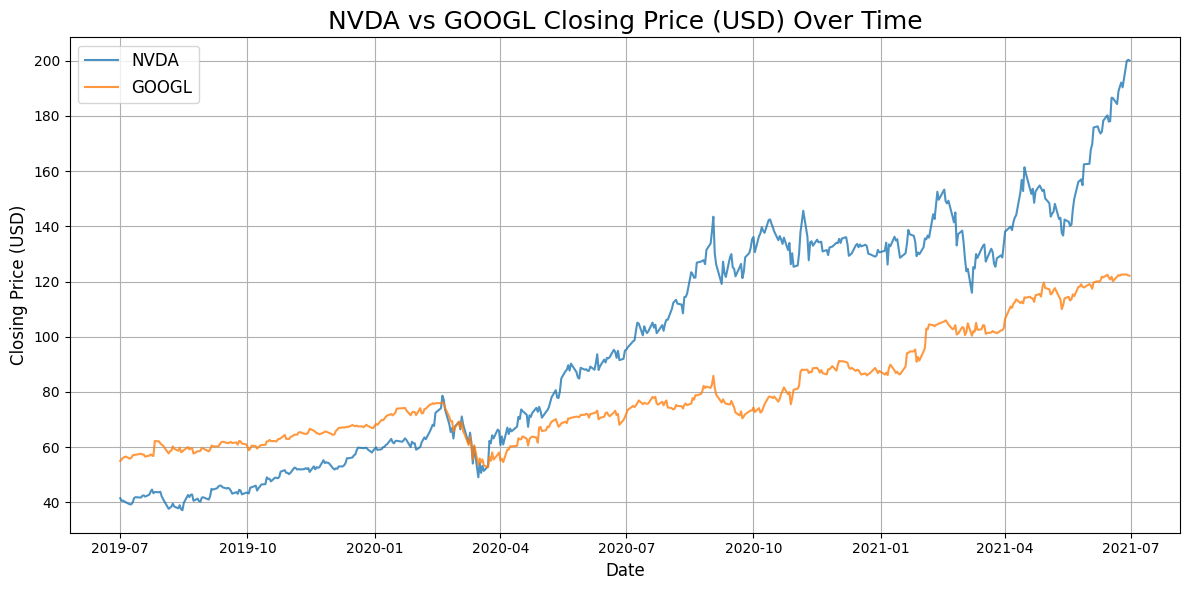

In [126]:
# Visualize.

X_df['Date'] = pd.to_datetime(X_df['Date'])
Y_df['Date'] = pd.to_datetime(Y_df['Date'])
X_time = X_df['Date']
Y_time = Y_df['Date']
X = X_df['Close']
Y = Y_df['Close']
x_label = 'NVDA'
y_label = 'GOOGL'
metric_name = "Closing Price (USD)"
title = f'{x_label} vs {y_label} {metric_name} Over Time'

plt.figure(figsize=(12, 6))
plt.plot(X_time, X, label=x_label, alpha=0.8)
plt.plot(Y_time, Y, label=y_label, alpha=0.8)
plt.title(title, fontsize=18)
plt.xlabel("Date",fontsize=12)
plt.ylabel(metric_name,fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


We can also visualize the time series with the rolling correlation overlaid.

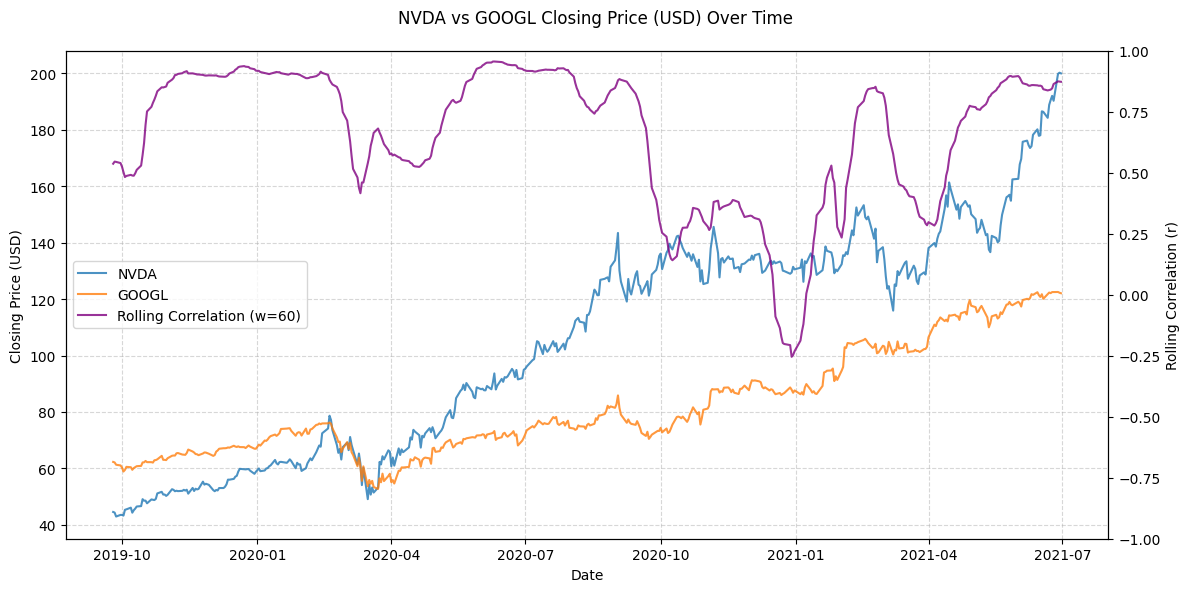

In [127]:
# Visualize rolling correlation along with the two data streams.

window = 60
r = rolling_corr_test(X, Y, window=window)
r_label = 'Rolling Correlation (w=60)'

# First y-axis for prices
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(X_time.iloc[window:], X.iloc[window:], label=x_label, alpha=0.8)
ax1.plot(Y_time.iloc[window:], Y.iloc[window:], label=y_label, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel(metric_name)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Second y-axis for rolling correlation
ax2 = ax1.twinx()
ax2.plot(X_time.iloc[window:], r.iloc[window:], label=r_label, alpha=0.8, color='purple')
ax2.set_ylabel("Rolling Correlation (r)")
ax2.set_ylim(-1, 1)  # Force correlation scale

fig.suptitle(title)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left')

plt.tight_layout()
plt.show()


Now, we apply the four detectors using the calibrated parameters from simulations, and map the results onto the chart.

In [128]:
# For clarity define data explicitly again.

X = X_df['Close']
Y = Y_df['Close']
window = 60
S = rolling_corr_test(X=X, Y=Y, window=window)


In [ ]:
# CUSUM

burn_in = 90; h = 0.7; k = 0.45

mu0_est = S.iloc[window:window+burn_in].mean()
data = S.iloc[window+burn_in:]

cusum_tau = detect_cusum(data, mu0_est, k, h)
cusum_tau += window + burn_in
cusum_tau


322

In [ ]:
# Wilcoxon Ranksum

w_min = 85; H = 12.4

data = S.iloc[window:]

ranksum_tau = detect_ranksum(x=data, w_min=w_min, H=H)[0]
ranksum_tau += window
ranksum_tau

386

In [131]:
# MEWMA

burn_in = 110; lam = 0.4; H = 13

mewma_tau = detect_mewma(x=X, y=Y, burn_in=burn_in, lam=lam, H=H)
mewma_tau

113

In [132]:
# Adaptive EWMA

burn_in = 90; h = 0.5; eta = 0.01; lam = 0.5

mu0_est = S.iloc[window:window+burn_in].mean()
data = S.iloc[window+burn_in:]

adaptive_ewma_tau = detect_adaptive_ewma(data, mu0=mu0_est, eta=eta, h=h, lam=lam)
adaptive_ewma_tau += window + burn_in
adaptive_ewma_tau


318

Based on the "best" parameters from simulated study, it seems that CUSUM, A-EWMA, and WRS are detecting a change at around 0.7 correlation point drop as calibrated during simulations, but with varying degrees of delay. However, MEWMA detected change much earlier than the other three.

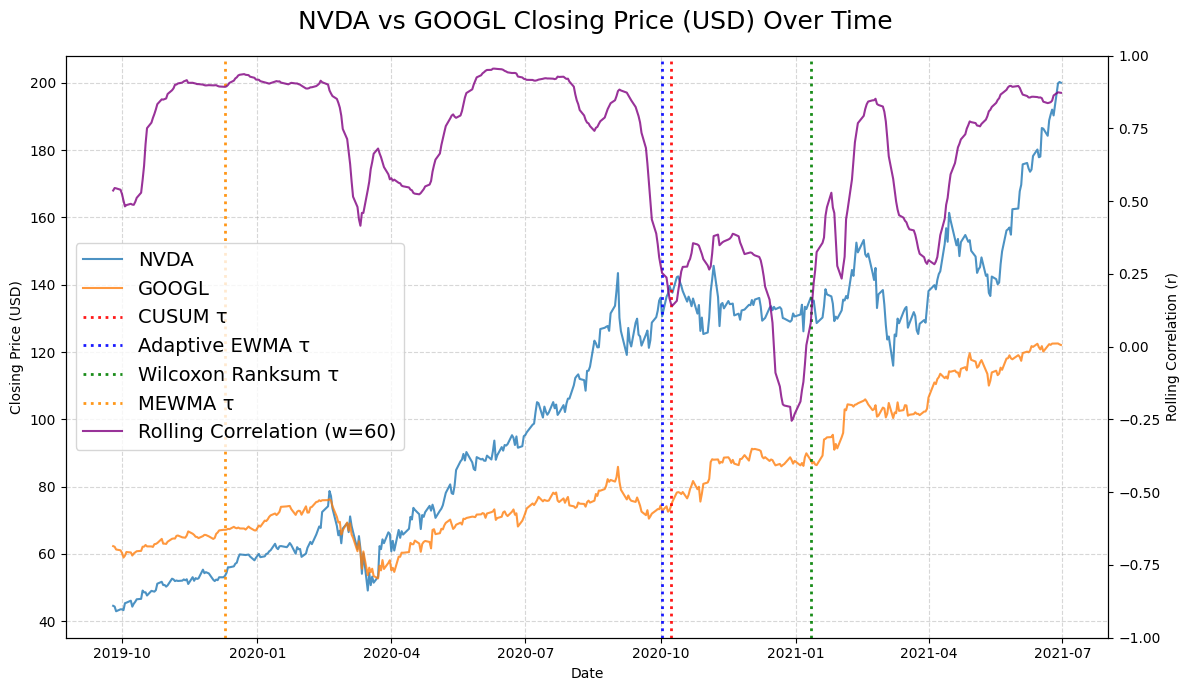

In [133]:
time_idx = X_time.iloc[window:]  # align dates with plotted slices

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(time_idx, X.iloc[window:], label=x_label, alpha=0.8)
ax1.plot(time_idx, Y.iloc[window:], label=y_label, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel(metric_name)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(time_idx, r.iloc[window:], label=r_label, alpha=0.8, color='purple')
ax2.set_ylabel("Rolling Correlation (r)")
ax2.set_ylim(-1, 1)

# Vertical lines at detected changepoints (map indices to dates)
ax1.axvline(X_time.iloc[cusum_tau], color='red', linestyle=':', label='CUSUM τ', linewidth=2, alpha=0.9)
ax1.axvline(X_time.iloc[adaptive_ewma_tau], color='blue', linestyle=':', label='Adaptive EWMA τ', linewidth=2, alpha=0.9)
ax1.axvline(X_time.iloc[ranksum_tau], color='green', linestyle=':', label="Wilcoxon Ranksum τ", linewidth=2, alpha=0.9)
ax1.axvline(X_time.iloc[mewma_tau], color='darkorange', linestyle=':', label='MEWMA τ', linewidth=2, alpha=0.9)

fig.suptitle(title, fontsize=18)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='center left', fontsize=14)

plt.tight_layout()
plt.show()


In [134]:
# Print detection times.

taus = {
    "CUSUM": cusum_tau,
    "A-EWMA": adaptive_ewma_tau,
    "Wilcoxon": ranksum_tau,
    "MEWMA": mewma_tau
}

summary = [
    (m, t, X_time.iloc[t].date(), float(r.iloc[t])) for m, t in taus.items()
]

summary.sort(key=lambda row: row[1])

for row in summary:
    print(f"{row[0]:9s} t={row[1]:4d}  date={row[2]}")


MEWMA     t= 113  date=2019-12-10
A-EWMA    t= 318  date=2020-10-02
CUSUM     t= 322  date=2020-10-08
Wilcoxon  t= 386  date=2021-01-11


## Case Study 2: COVID-19 in LA vs. SF

Next, we look at COVID-19 daily cases in LA vs. SF counties between March 2020 and March 2021. 

(Source: https://www.kaggle.com/datasets/fireballbyedimyrnmom/us-counties-covid-19-dataset)

In [135]:
# Import data.

dataset = kagglehub.dataset_download("fireballbyedimyrnmom/us-counties-covid-19-dataset")
df = pd.read_csv(dataset + "/us-counties.csv")

df['date'] = pd.to_datetime(df['date']).dt.normalize()
counties = ['Los Angeles', 'San Francisco']
df = df.loc[
            (df['state'] == 'California') & (df['county'].isin(counties)),
            ['date', 'county', 'cases']
        ].groupby(['date', 'county'], as_index=False)['cases'].max()


In [136]:
# Calculate daily cases per 10k capita and pivot.

county_population = {
    'Los Angeles': 9996634,
    'San Francisco': 874826,
}

cases_df = df.sort_values(['county', 'date'])
cases_df['new_cases'] = cases_df.groupby('county')['cases'].diff().fillna(0)
cases_df['new_cases'] = cases_df['new_cases'].clip(lower=0)
cases_df['per100k'] = cases_df.apply(lambda r: (r['new_cases'] / county_population[r['county']]) * 100_000, axis=1)
cases_df = cases_df.pivot(index='date', columns='county', values='per100k').sort_index()
cases_df = cases_df.loc['2020-03-01':'2021-03-01']


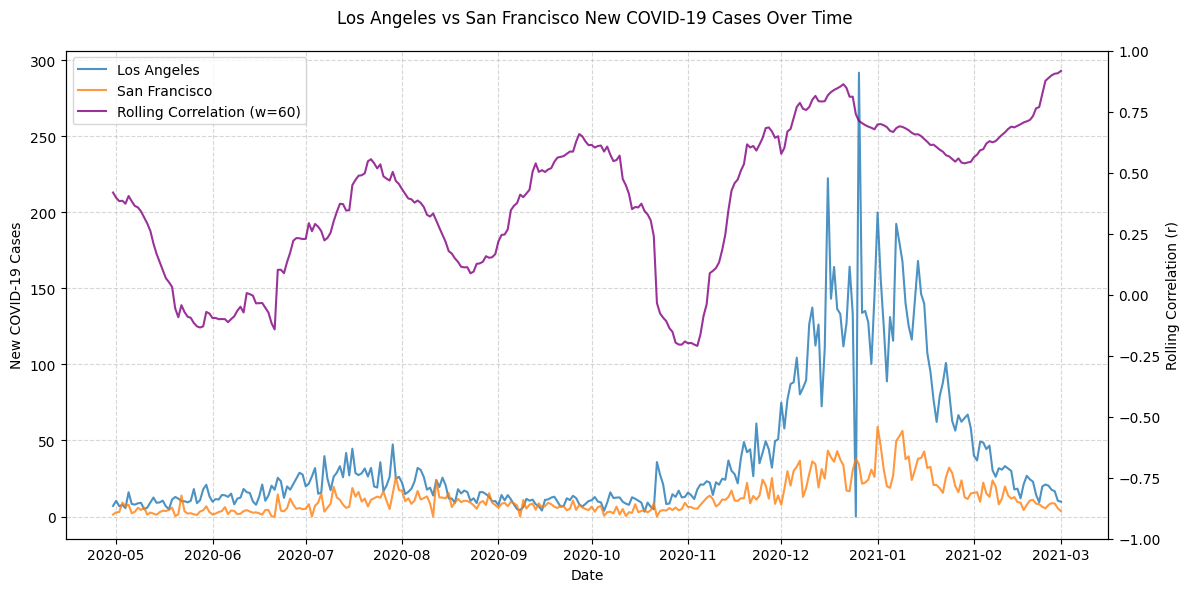

In [137]:
# Visualize rolling correlation along with the two data streams.

time_idx = cases_df.index
X = cases_df['Los Angeles']
Y = cases_df['San Francisco']
x_label = 'Los Angeles'
y_label = 'San Francisco'
metric_name = "New COVID-19 Cases"
title = f'{x_label} vs {y_label} {metric_name} Over Time'

window = 60
r = rolling_corr_test(X, Y, window=window)
r_label = 'Rolling Correlation (w=60)'


# First y-axis for prices
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(time_idx[window:], X.iloc[window:], label=x_label, alpha=0.8)
ax1.plot(time_idx[window:], Y.iloc[window:], label=y_label, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel(metric_name)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Second y-axis for rolling correlation
ax2 = ax1.twinx()
ax2.plot(time_idx[window:], r.iloc[window:], label=r_label, alpha=0.8, color='purple')
ax2.set_ylabel("Rolling Correlation (r)")
ax2.set_ylim(-1, 1)  # Force correlation scale

fig.suptitle(title)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


We run the four detectors on this data.

In [138]:
# For clarity define data explicitly again.

X = cases_df['Los Angeles']
Y = cases_df['San Francisco']
window = 60
S = rolling_corr_test(X=X, Y=Y, window=window)


In [139]:
# CUSUM 

burn_in = 90; h = 0.7; k = 0.45

mu0_est = S.iloc[window:window+burn_in].mean()
data = S.iloc[window+burn_in:]

cusum_tau = detect_cusum(data, mu0_est, k, h)
cusum_tau += window + burn_in
cusum_tau


282

In [ ]:
# Wilcoxon Ranksum

w_min = 85; H = 12.4

data = S.iloc[window:]

ranksum_tau = detect_ranksum(x=data, w_min=w_min, H=H)[0]
ranksum_tau += window
ranksum_tau


344

In [141]:
# MEWMA

burn_in = 110; lam = 0.4; H = 13

mewma_tau = detect_mewma(x=X, y=Y, burn_in=burn_in, lam=lam, H=H)
mewma_tau


112

In [142]:
# Adaptive EWMA

burn_in = 90; h = 0.5; eta = 0.01; lam = 0.5

S = rolling_corr_test(X=X, Y=Y, window=window)
mu0_est = S.iloc[window:window+burn_in].mean()
data = S.iloc[window+burn_in:]

adaptive_ewma_tau = detect_adaptive_ewma(data, mu0=mu0_est, eta=eta, h=h, lam=lam)
adaptive_ewma_tau += window + burn_in
adaptive_ewma_tau


280

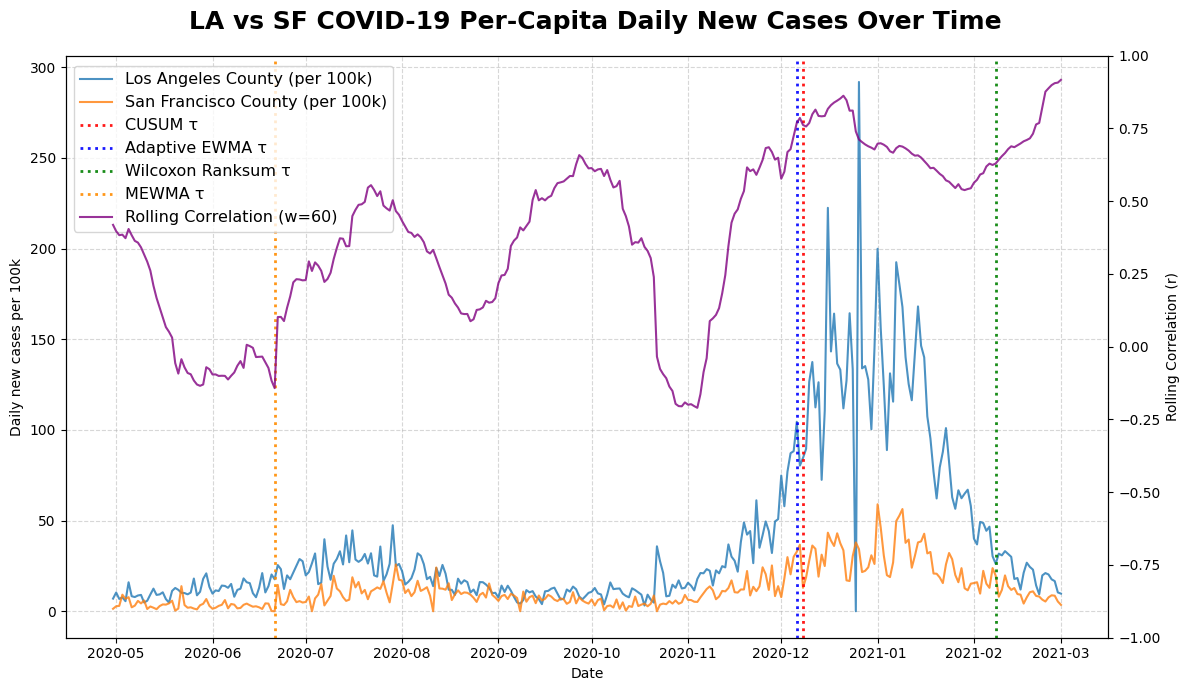

In [143]:
window = 60
r = rolling_corr_test(cases_df['Los Angeles'], cases_df['San Francisco'], window=window)

x_label = 'Los Angeles County (per 100k)'
y_label = 'San Francisco County (per 100k)'
r_label = 'Rolling Correlation (w=60)'

time_idx = cases_df.index[window:]  # align with plotted slices

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(time_idx, cases_df['Los Angeles'].iloc[window:], label=x_label, alpha=0.8)
ax1.plot(time_idx, cases_df['San Francisco'].iloc[window:], label=y_label, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily new cases per 100k")
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(time_idx, r.iloc[window:], label=r_label, alpha=0.8, color='purple')
ax2.set_ylabel("Rolling Correlation (r)")
ax2.set_ylim(-1, 1)

# Vertical lines at detected changepoints (using your existing vars)
if cusum_tau is not None:
    ax1.axvline(cases_df.index[cusum_tau], color='red', linestyle=':', label='CUSUM τ', linewidth=2, alpha=0.9)
if adaptive_ewma_tau is not None:
    ax1.axvline(cases_df.index[adaptive_ewma_tau], color='blue', linestyle=':', label='Adaptive EWMA τ', linewidth=2, alpha=0.9)
if ranksum_tau is not None:
    ax1.axvline(cases_df.index[ranksum_tau], color='green', linestyle=':', label='Wilcoxon Ranksum τ', linewidth=2, alpha=0.9)
if mewma_tau is not None:
    ax1.axvline(cases_df.index[mewma_tau], color='darkorange', linestyle=':', label='MEWMA τ', linewidth=2, alpha=0.9)

fig.suptitle("LA vs SF COVID-19 Per-Capita Daily New Cases Over Time", fontsize=18, fontweight="bold")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='center left', fontsize=11.5,
           bbox_to_anchor=(0, 0.84))  # (x, y) shift

plt.tight_layout()
plt.show()


In [144]:
taus = {
    "A-EWMA": adaptive_ewma_tau,
    "CUSUM": cusum_tau,
    "Wilcoxon": ranksum_tau,
    "MEWMA": mewma_tau
}

time_idx = cases_df.index
r = rolling_corr_test(cases_df['Los Angeles'], cases_df['San Francisco'], window=window)

summary = []
for method, t in taus.items():
    if t is not None and 0 <= t < len(time_idx):
        summary.append((method, t, time_idx[t].date(), float(r.iloc[t])))

summary.sort(key=lambda row: row[1])

for row in summary:
    print(f"{row[0]:9s} t={row[1]:4d} date={row[2]}")


MEWMA     t= 112 date=2020-06-21
A-EWMA    t= 280 date=2020-12-06
CUSUM     t= 282 date=2020-12-08
Wilcoxon  t= 344 date=2021-02-08


## Case Study 3: Zoom vs S&P500

Finally, we look at Zoom vs. S&P 500 returns between April 2019 and December 2020. 

(Source for Zoom dataset: https://www.kaggle.com/datasets/ranugadisansagamage/zoom-stocks;

source for S&P 500 dataset: https://www.kaggle.com/datasets/ancyneuray/sp500-2005-2025)

In [145]:
# Import data.

# Zoom 2019-04-18 to 2022-05-20
dataset_zoom = kagglehub.dataset_download("ranugadisansagamage/zoom-stocks")
X_df = pd.read_csv(dataset_zoom + "/Zoom.csv")

# S&P 500 July 2005 to June 2025
dataset_sp500 = kagglehub.dataset_download("ancyneuray/sp500-2005-2025")
Y_df = pd.read_csv(dataset_sp500 + "/SP500.csv")

In [146]:
# Format date & join streams into one df.

start_date = '2019-04-18'
end_date = '2020-12-31'
X_df['Date'] = pd.to_datetime(X_df['Date'])
X_df = X_df[(X_df['Date'] >= start_date) & (X_df['Date'] <= end_date)]
Y_df['Date'] = pd.to_datetime(Y_df['Date'], format='%d-%m-%Y')
Y_df = Y_df[(Y_df['Date'] >= start_date) & (Y_df['Date'] <= end_date)]

combined_df = pd.merge(X_df[['Date','Close']], 
                       Y_df[['Date','Close']], 
                       on='Date', how='inner', 
                       suffixes=('_ZM', '_SPX'))


In [147]:
# Calculate daily returns & performance (for visualization)

combined_df['Returns_ZM'] = combined_df['Close_ZM'].pct_change()
combined_df['Returns_SPX'] = combined_df['Close_SPX'].pct_change()
combined_df['Perf_ZM'] = (1 + combined_df['Returns_ZM']).cumprod().fillna(1)
combined_df['Perf_SPX'] = (1 + combined_df['Returns_SPX']).cumprod().fillna(1)


The correlation is calculated based on each stock's returns.

For visualization only, we plot the **performance of each stock** (i.e. how much $1 on day 1 would result on the subsequent days) along with the correlation of the **returns**.

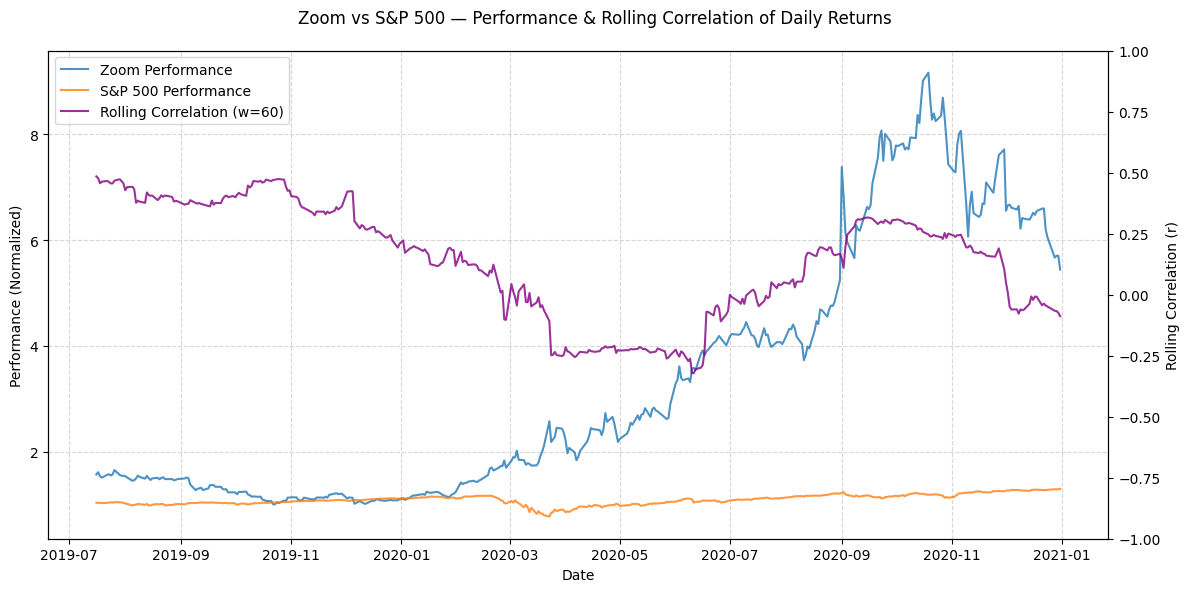

In [148]:
# Visualize the series with r.

x_label = "Zoom Performance"
y_label = "S&P 500 Performance"

window = 60
r = combined_df['Returns_ZM'].rolling(window).corr(combined_df['Returns_SPX'])
r_label = 'Rolling Correlation (w=60)'

# First y-axis for performance curves
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(combined_df['Date'][window:], combined_df['Perf_ZM'][window:], label=x_label, alpha=0.8)
ax1.plot(combined_df['Date'][window:], combined_df['Perf_SPX'][window:], label=y_label, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel("Performance (Normalized)")
ax1.grid(True, linestyle="--", alpha=0.5)

# Second y-axis for rolling correlation
ax2 = ax1.twinx()
ax2.plot(combined_df['Date'][window:], r[window:], label=r_label, alpha=0.8, color='purple')
ax2.set_ylabel("Rolling Correlation (r)")
ax2.set_ylim(-1, 1)

fig.suptitle("Zoom vs S&P 500 — Performance & Rolling Correlation of Daily Returns")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()
plt.show()


Next, we apply the four detectors to the data.

In [149]:
# For clarity define data explicitly again.

X = combined_df['Returns_ZM']
Y = combined_df['Returns_SPX']
window = 60
S = rolling_corr_test(X=X, Y=Y, window=window)


In [150]:
# CUSUM 

burn_in = 90; h = 0.7; k = 0.45

mu0_est = S.iloc[window:window+burn_in].mean()
data = S.iloc[window+burn_in:]

cusum_tau = detect_cusum(data, mu0_est, k, h)
cusum_tau += window + burn_in
cusum_tau


237

In [ ]:
# Wilcoxon Ranksum

w_min = 85; H = 12.4

data = S.iloc[window:]

ranksum_tau = detect_ranksum(x=data, w_min=w_min, H=H)[0]
ranksum_tau += window
ranksum_tau

267

In [152]:
# MEWMA

burn_in = 110; lam = 0.4; H = 13

mewma_tau = detect_mewma(x=X, y=Y, burn_in=burn_in, lam=lam, H=H)
print(mewma_tau)


None


In [153]:
# Adaptive EWMA

burn_in = 90; h = 0.5; eta = 0.01; lam = 0.5

mu0_est = S.iloc[window:window+burn_in].mean()
data = S.iloc[window+burn_in:]

adaptive_ewma_tau = detect_adaptive_ewma(data, mu0=mu0_est, eta=eta, h=h, lam=lam)
adaptive_ewma_tau += window + burn_in
adaptive_ewma_tau


235

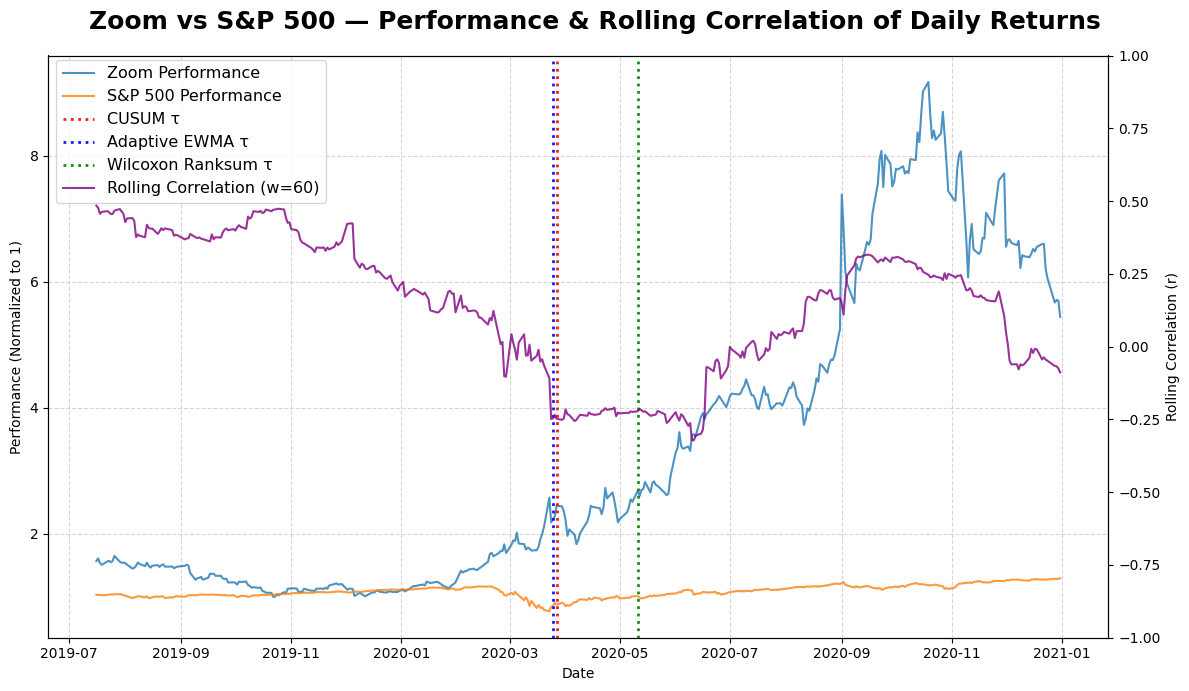

In [154]:
# Visualize results.

time_idx = combined_df['Date'].iloc[window:]

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(time_idx, combined_df['Perf_ZM'].iloc[window:], label=x_label, alpha=0.8)
ax1.plot(time_idx, combined_df['Perf_SPX'].iloc[window:], label=y_label, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel("Performance (Normalized to 1)")
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(time_idx, r.iloc[window:], label=r_label, alpha=0.8, color='purple')
ax2.set_ylabel("Rolling Correlation (r)")
ax2.set_ylim(-1, 1)

# Vertical lines at detected changepoints
if cusum_tau is not None:
    ax1.axvline(combined_df['Date'].iloc[cusum_tau], 
                color='red', linestyle=':', label='CUSUM τ', linewidth=2, alpha=0.9)
if adaptive_ewma_tau is not None:
    ax1.axvline(combined_df['Date'].iloc[adaptive_ewma_tau], 
                color='blue', linestyle=':', label='Adaptive EWMA τ', linewidth=2, alpha=0.9)
if ranksum_tau is not None:
    ax1.axvline(combined_df['Date'].iloc[ranksum_tau], 
                color='green', linestyle=':', label='Wilcoxon Ranksum τ', linewidth=2, alpha=0.9)
if mewma_tau is not None:
    ax1.axvline(combined_df['Date'].iloc[mewma_tau], 
                color='darkorange', linestyle=':', label='MEWMA τ', linewidth=2, alpha=0.9)

fig.suptitle("Zoom vs S&P 500 — Performance & Rolling Correlation of Daily Returns", 
             fontsize=18, fontweight="bold")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='center left', fontsize=11.5,
           bbox_to_anchor=(0, 0.87))

plt.tight_layout()
plt.show()


In [155]:
taus = {
    "A-EWMA": adaptive_ewma_tau,
    "CUSUM": cusum_tau,
    "Wilcoxon": ranksum_tau,
    "MEWMA": mewma_tau,
}

combined_df = combined_df.sort_values('Date').reset_index(drop=True)
time_idx = pd.to_datetime(combined_df['Date'])
r = combined_df['Returns_ZM'].rolling(window).corr(combined_df['Returns_SPX'])

summary = []
for method, t in taus.items():
    if t is not None and 0 <= t < len(time_idx):
        summary.append((method, t, time_idx.iloc[t].date(), float(r.iloc[t])))

summary.sort(key=lambda row: row[1])

for row in summary:
    print(f"{row[0]:9s} t={row[1]:4d} date={row[2]}")

A-EWMA    t= 235 date=2020-03-25
CUSUM     t= 237 date=2020-03-27
Wilcoxon  t= 267 date=2020-05-11
